In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

In [105]:

# ----------------------------
# 1. Load and Clean Data
# ----------------------------
# File paths
futures_filepath = '/Users/markbogorad/Desktop/NYU_MFE/Semester_2/1.2_Trading_Energy_Derivatives_MATH_GA_2800/Oil_Project/Systematic_Energy_Trading/Data/rolling_test.xlsx'
calendar_filepath = '/Users/markbogorad/Desktop/NYU_MFE/Semester_2/1.2_Trading_Energy_Derivatives_MATH_GA_2800/Oil_Project/Systematic_Energy_Trading/Data/expiration_calendar.xlsx'

def load_futures_data(futures_filepath):
    df = pd.read_excel(futures_filepath, sheet_name='WTI')
    df['Date'] = pd.to_datetime(df['Date'])
    df['WTI_F_1'] = df['WTI F_1'].replace('[\\$,]', '', regex=True).astype(float)
    df['WTI_F_2'] = df['WTI F_2'].replace('[\\$,]', '', regex=True).astype(float)
    return df

futures_df = load_futures_data(futures_filepath)
df = load_futures_data(futures_filepath)

df.head

<bound method NDFrame.head of            Date  WTI F_1  WTI F_2  WTI_F_1  WTI_F_2
0    2010-01-04    81.51    82.12    81.51    82.12
1    2010-01-05    81.77    82.41    81.77    82.41
2    2010-01-06    83.18    83.75    83.18    83.75
3    2010-01-07    82.66    83.19    82.66    83.19
4    2010-01-08    82.75    83.30    82.75    83.30
...         ...      ...      ...      ...      ...
3520 2023-12-26    75.57    75.71    75.57    75.71
3521 2023-12-27    74.11    74.34    74.11    74.34
3522 2023-12-28    71.77    71.97    71.77    71.97
3523 2023-12-29    71.65    71.84    71.65    71.84
3524 2024-01-02    70.38    70.62    70.38    70.62

[3525 rows x 5 columns]>

In [106]:
# ----------------------------
# 2. Define and Check Rolling Calendar
# ----------------------------

def load_roll_calendar(filepath, futures_df):
    # Load the expiration calendar
    calendar_df = pd.read_excel(filepath, sheet_name='Expiration Calendar', header=None)
    calendar_df.columns = ['Expiry']
    calendar_df['Expiry'] = pd.to_datetime(calendar_df['Expiry'])
    
    # Calculate tentative roll dates
    calendar_df['Tentative Roll Date'] = calendar_df['Expiry'] - BDay(5)
    
    # Adjust roll dates to match closest previous available futures date
    adjusted_roll_dates = []
    for tentative_date in calendar_df['Tentative Roll Date']:
        # Find the closest previous date in the futures data
        valid_dates = futures_df[futures_df['Date'] <= tentative_date]['Date']
        if not valid_dates.empty:
            closest_date = valid_dates.iloc[-1]
            adjusted_roll_dates.append(closest_date)
        else:
            # If no valid date, fallback to the tentative date
            adjusted_roll_dates.append(tentative_date)


    # Finalize adjusted roll dates
    calendar_df['Adjusted Roll Date'] = adjusted_roll_dates

    # Display for manual validation
    display(calendar_df[['Expiry', 'Tentative Roll Date', 'Adjusted Roll Date']].head(10))
    
    return calendar_df

calendar_df = load_roll_calendar(calendar_filepath, futures_df)



,Expiry,Tentative Roll Date,Adjusted Roll Date
0,2005-12-20,2005-12-13,2005-12-13
1,2006-01-20,2006-01-13,2006-01-13
2,2006-02-21,2006-02-14,2006-02-14
3,2006-03-21,2006-03-14,2006-03-14
4,2006-04-20,2006-04-13,2006-04-13
5,2006-05-22,2006-05-15,2006-05-15
6,2006-06-20,2006-06-13,2006-06-13
7,2006-07-20,2006-07-13,2006-07-13
8,2006-08-22,2006-08-15,2006-08-15
9,2006-09-20,2006-09-13,2006-09-13


In [119]:
# ----------------------------
# 3. Integrate Roll Calendar into Futures Data
# ----------------------------
def integrate_roll_calendar(df, calendar_df):
    # Define roll dates and expiry dates
    roll_dates = calendar_df['Adjusted Roll Date'].tolist()
    expiry_dates = calendar_df['Expiry'].tolist()

    # Initialize Roll column (0 = Hold, 1 = Roll Day, 2 = Expiry Day)
    df['Roll'] = 0
    df.loc[df['Date'].isin(roll_dates), 'Roll'] = 1
    df.loc[df['Date'].isin(expiry_dates), 'Roll'] = 2

    # Define which contract is being held (F1 by default)
    holding_contract = []
    current_contract = 'F1'

    for idx, row in df.iterrows():
        if row['Roll'] == 1:
            current_contract = 'F2'  # Switch to F2 after rolling
        elif row['Roll'] == 2:
            current_contract = 'F1'  # Reset to F1 after expiry
        holding_contract.append(current_contract)

    df['Holding'] = holding_contract

    # Define actions
    df['Action'] = 'Hold'
    df.loc[df.index[0], 'Action'] = 'Buy'              # Initial buy
    df.loc[df['Roll'] == 1, 'Action'] = 'Sell & Buy'   # Transaction on roll day
    df.loc[df.index[-1], 'Action'] = 'Sell'            # Final sell on the last day

    # Display to validate the roll, holding, and action logic
    display(df[['Date', 'WTI_F_1', 'WTI_F_2', 'Roll', 'Holding', 'Action']].head(20))

    return df

futures_df = integrate_roll_calendar(futures_df, calendar_df)



,Date,WTI_F_1,WTI_F_2,Roll,Holding,Action
0,2010-01-04,81.51,82.12,0,F1,Buy
1,2010-01-05,81.77,82.41,0,F1,Hold
2,2010-01-06,83.18,83.75,0,F1,Hold
3,2010-01-07,82.66,83.19,0,F1,Hold
4,2010-01-08,82.75,83.30,0,F1,Hold
5,2010-01-11,82.52,83.01,0,F1,Hold
6,2010-01-12,80.79,81.17,1,F2,Sell & Buy
7,2010-01-13,79.65,80.04,0,F2,Hold
8,2010-01-14,79.39,79.88,0,F2,Hold
9,2010-01-15,78.00,78.37,0,F2,Hold


In [165]:
# ----------------------------
# 3. Calculate Rolling Futures
# ----------------------------
def calculate_rolling_futures(df, transaction_cost=0.01):
    rolling_futures = []
    rolling_pnl = []
    cumulative_costs = []
    total_cost = 0

    for idx in range(len(df)):
        t_cost = 0

        # First Day - Buy F1
        if idx == 0:
            t_cost = transaction_cost
            total_cost += t_cost
            rolling_futures.append(df.loc[idx, 'WTI_F_1'] - t_cost)
            rolling_pnl.append(0)

        else:
            # Roll Day: Still with F1
            if df.loc[idx, 'Roll'] == 1:
                change = df.loc[idx, 'WTI_F_1'] - df.loc[idx - 1, 'WTI_F_1']
                t_cost = 2 * transaction_cost

            # Expiry Day: Use F1(t) - F2(t-1)
            elif df.loc[idx, 'Roll'] == 2:
                change = df.loc[idx, 'WTI_F_1'] - df.loc[idx - 1, 'WTI_F_2']

            # Normal Day: Follow current holding
            else:
                if df.loc[idx - 1, 'Holding'] == 'F1':
                    change = df.loc[idx, 'WTI_F_1'] - df.loc[idx - 1, 'WTI_F_1']
                else:
                    change = df.loc[idx, 'WTI_F_2'] - df.loc[idx - 1, 'WTI_F_2']

            # Update cumulative costs and rolling futures value
            total_cost += t_cost
            adjusted_value = rolling_futures[-1] + change - t_cost
            rolling_futures.append(adjusted_value)
            rolling_pnl.append(change - t_cost)

        cumulative_costs.append(total_cost)

    # Assign the action-based transaction costs
    df['Transaction Costs'] = [
        transaction_cost if action == 'Buy' else
        2 * transaction_cost if action == 'Sell & Buy' else
        transaction_cost if action == 'Sell' else 0 
        for action in df['Action']
    ]
    
    df['Rolling Futures PnL'] = rolling_pnl
    df['Rolling Futures'] = rolling_futures
    df['Cumulative Transaction Costs'] = cumulative_costs

    return df

# Run the updated function
futures_df = calculate_rolling_futures(futures_df, transaction_cost=0.01)

# Display for validation
display(futures_df[['Date', 'WTI_F_1', 'WTI_F_2', 'Roll', 'Holding', 'Action', 'Transaction Costs',
                    'Rolling Futures PnL', 'Rolling Futures', 'Cumulative Transaction Costs']].head(30))


,Date,WTI_F_1,WTI_F_2,Roll,Holding,Action,Transaction Costs,Rolling Futures PnL,Rolling Futures,Cumulative Transaction Costs
0,2010-01-04,81.51,82.12,0,F1,Buy,0.01,0.00,81.50,0.01
1,2010-01-05,81.77,82.41,0,F1,Hold,0.00,0.26,81.76,0.01
2,2010-01-06,83.18,83.75,0,F1,Hold,0.00,1.41,83.17,0.01
3,2010-01-07,82.66,83.19,0,F1,Hold,0.00,-0.52,82.65,0.01
4,2010-01-08,82.75,83.30,0,F1,Hold,0.00,0.09,82.74,0.01
5,2010-01-11,82.52,83.01,0,F1,Hold,0.00,-0.23,82.51,0.01
6,2010-01-12,80.79,81.17,1,F2,Sell & Buy,0.02,-1.75,80.76,0.03
7,2010-01-13,79.65,80.04,0,F2,Hold,0.00,-1.13,79.63,0.03
8,2010-01-14,79.39,79.88,0,F2,Hold,0.00,-0.16,79.47,0.03
9,2010-01-15,78.00,78.37,0,F2,Hold,0.00,-1.51,77.96,0.03


In [167]:
# ----------------------------
# 5. Metrics
# ----------------------------
def calculate_metrics(df):
    # Extract first and last Rolling Futures values
    first_rolling_value = df['Rolling Futures'].iloc[0]
    last_rolling_value = df['Rolling Futures'].iloc[-1]
    
    # Calculate PnL using the provided formula
    pnl = (last_rolling_value - first_rolling_value) * 100 * 1000
    
    # Calculate total transaction costs
    total_transaction_costs = df['Cumulative Transaction Costs'].iloc[-1] * 100 * 1000
    
    # Metrics dictionary
    metrics = {
        'Rolling Futures PnL': pnl,
        'Total Transaction Costs': total_transaction_costs
    }
    
    # Display metrics
    print("\nWTI Final Figures:")
    for key, value in metrics.items():
        print(f"{key}: ${value:,.2f}")
    
    return metrics

metrics = calculate_metrics(futures_df)



WTI Final Figures:
Rolling Futures PnL: $-5,225,000.00
Total Transaction Costs: $337,000.00


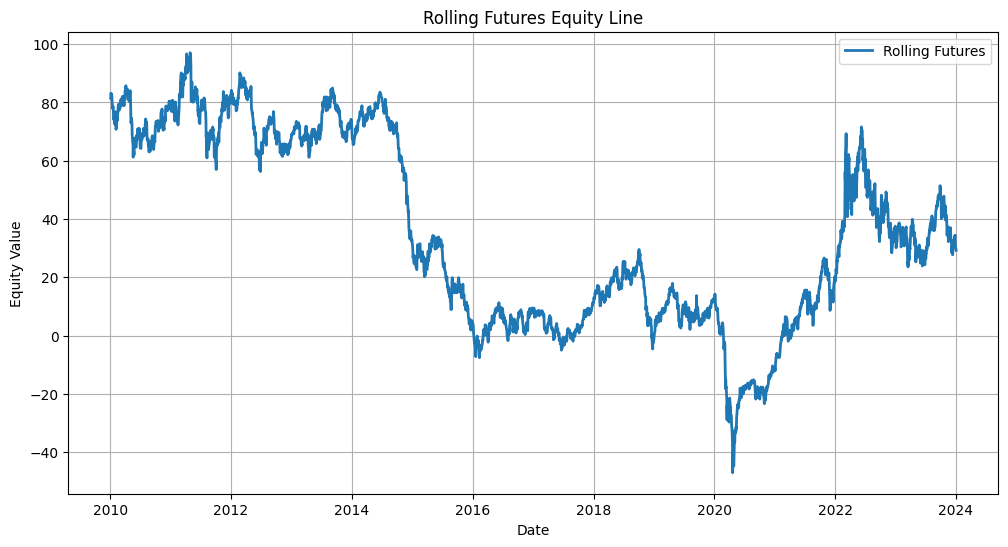

In [168]:
# ----------------------------
# 6. Plot the Rolling Futures Equity Line
# ----------------------------

def plot_rolling_futures(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Rolling Futures'], label='Rolling Futures', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Equity Value')
    plt.title('Rolling Futures Equity Line')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rolling_futures(futures_df)
